In [3]:
import os 
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

In [4]:
import torch
import GPUtil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

from vecopsciml.operators.zero_order import Mx, My
from utils.checkpoints import load_results

from architectures.pgnniv_baseline import PGNNIVBaseline

In [5]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/sigmoid_nonlinear/sigmoid_nonlinear.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/transfer_learning')

PRETRAINED_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/non_linear_1000_0/baseline_model_10')
MODEL_RESULTS_TRANSFERLEARNING_PATH = os.path.join(ROOT_PATH, r'results/transfer_learning/transfer')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_TRANSFERLEARNING_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/transfer_learning
Folder successfully created at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/transfer_learning/transfer


In [7]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/sigmoid_nonlinear/sigmoid_nonlinear.pkl


In [8]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [9]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda:1


### División de los datos

In [10]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
y_train = torch.Tensor(dataset['y_train']).unsqueeze(1)
K_train = torch.tensor(dataset['k_train']).unsqueeze(1)
f_train = torch.tensor(dataset['f_train']).unsqueeze(1).to(torch.float32)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.Tensor(dataset['y_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

print("Train dataset length:", len(X_train))
print("Validation dataset length:", len(X_val))

Train dataset length: 800
Validation dataset length: 200


In [11]:
X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X_train, y_train, K_train, f_train, test_size=0.2, random_state=42)

X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

In [12]:
# Other parameters
n_filters_explanatory = 5
n_modes = 10

# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10]
explanatory_output = Mx(My(f_train)).values[0].shape

In [13]:
# pretrained_autoencoder = PretrainedAutoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
pretrained_pgnniv = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(pretrained_pgnniv.parameters(), lr=1e-4)
pretrained_pgnniv, optimizer, lists = load_results(pretrained_pgnniv, optimizer, PRETRAINED_RESULTS_PATH, map_location=torch.device('cpu'))

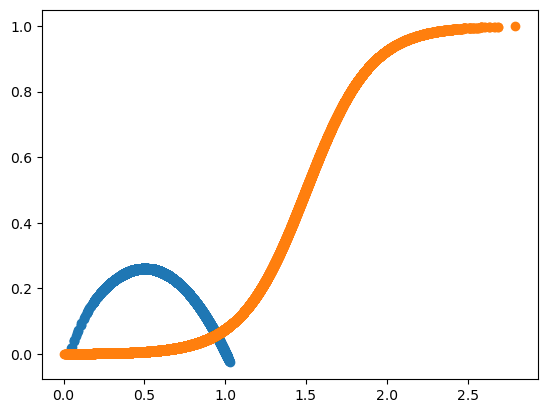

In [14]:
plt.scatter(Mx(My(TensOps(pretrained_pgnniv(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            pretrained_pgnniv(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())

In [ ]:
pgnniv_pretrained_encoder = pretrained_pgnniv.encoder

for param in pgnniv_pretrained_encoder.parameters():
    param.requires_grad = False

# for name, param in pgnniv_pretrained_encoder.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

hidden1_layer.weight: requires_grad=False
hidden1_layer.bias: requires_grad=False
hidden2_layer.weight: requires_grad=False
hidden2_layer.bias: requires_grad=False
latent_space_layer.weight: requires_grad=False
latent_space_layer.bias: requires_grad=False


In [ ]:
# explanatory_layers = [100]

model = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

# Parametros de entrenamiento
start_epoch = 0
n_epochs = 100000

batch_size = 64
n_checkpoints = 3

train_loop(model, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
           D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_TRANSFERLEARNING_PATH, device=DEVICE)

Starting training from scratch.
Epoch 0, Train loss: 8.514e+11, Test loss: 7.937e+11, MSE(e): 8.484e+01, MSE(pi1): 2.735e+02, MSE(pi2): 3.617e+01, MSE(pi3): 2.912e+00
Epoch 10, Train loss: 9.765e+10, Test loss: 1.392e+11, MSE(e): 9.718e+00, MSE(pi1): 2.264e+01, MSE(pi2): 4.382e+00, MSE(pi3): 2.371e+00
Epoch 20, Train loss: 2.331e+10, Test loss: 3.248e+10, MSE(e): 2.285e+00, MSE(pi1): 2.269e+01, MSE(pi2): 1.389e+00, MSE(pi3): 2.343e+00
Epoch 30, Train loss: 1.923e+10, Test loss: 2.085e+10, MSE(e): 1.877e+00, MSE(pi1): 2.273e+01, MSE(pi2): 1.227e+00, MSE(pi3): 2.303e+00
Epoch 40, Train loss: 1.800e+10, Test loss: 1.761e+10, MSE(e): 1.755e+00, MSE(pi1): 2.273e+01, MSE(pi2): 1.175e+00, MSE(pi3): 2.260e+00
Epoch 50, Train loss: 1.743e+10, Test loss: 1.616e+10, MSE(e): 1.698e+00, MSE(pi1): 2.268e+01, MSE(pi2): 1.152e+00, MSE(pi3): 2.211e+00
Epoch 60, Train loss: 1.720e+10, Test loss: 1.546e+10, MSE(e): 1.676e+00, MSE(pi1): 2.256e+01, MSE(pi2): 1.143e+00, MSE(pi3): 2.150e+00
Epoch 70, Train l

In [ ]:
start_epoch = n_epochs-1
n_epochs = 150000

batch_size = 64 
n_checkpoints = 3

second_lr = 3e-4

train_loop(model, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
           D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_TRANSFERLEARNING_PATH, device=DEVICE)

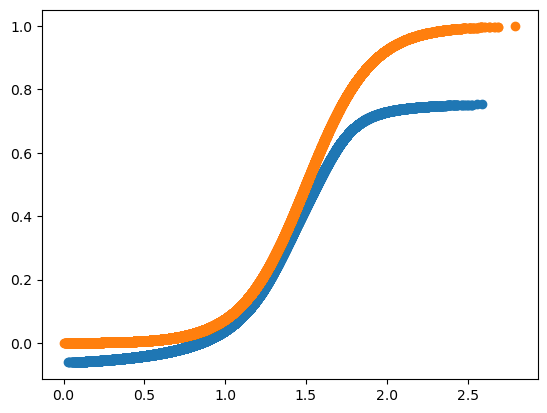

In [18]:
plt.scatter(Mx(My(TensOps(model(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            model(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())